In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

2025-02-13 17:17:47.365416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 17:17:47.366530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 17:17:47.369534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 17:17:47.379196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739467067.395980   34054 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739467067.40

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Image shape: (256, 256, 3)
label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Image shape: (256, 256, 3)
label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


2025-02-13 17:18:32.198013: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


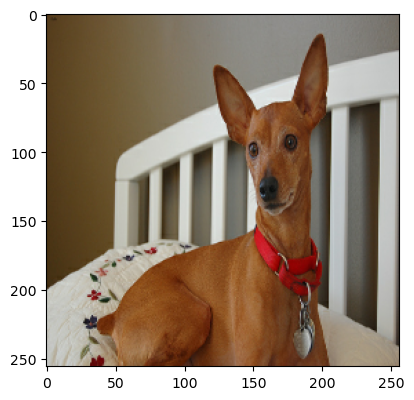

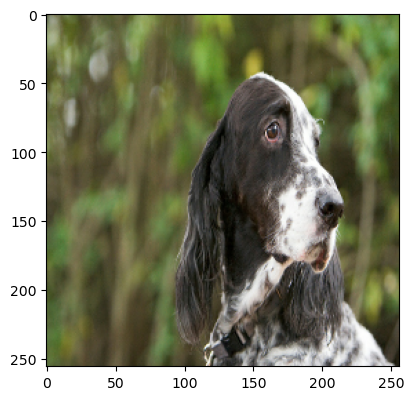

In [8]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, get_augmentation_layers

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name





#train = train.map(lambda x: resize_normalize(x, img_size))
#val = val.map(lambda x: resize_normalize(x, img_size))
#test = test.map(lambda x: resize_normalize(x, img_size))

print("\n")

'''for image, label in train.take(1):
    plt.imshow(image)
    print("Label shape:", label.shape)
    print("Label values:", label.numpy())  # Optional: To see the one-hot encoded values'''

for i, example in enumerate(train.take(2)):  # Take two examples
    print("Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print("label = ", label.numpy())
    #mask = example['segmentation_mask']  # This is the segmentation mask
    #plt.imshow(mask, cmap='gray', alpha=0.5)
    #print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
plt.show()

In [3]:
train

<_MapDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(37,), dtype=tf.float32, name=None), 'segmentation_mask': TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)}>

In [9]:
data_augmentation = get_augmentation_layers()

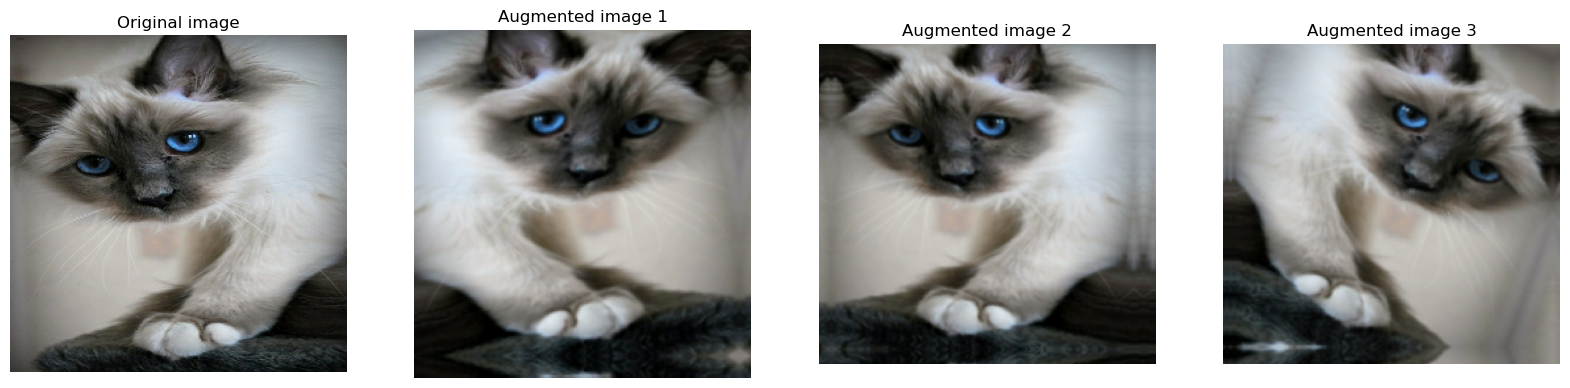

In [27]:
for example in train.take(1):
    image = example['image']
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

In [6]:
BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                      
test_ds = test.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)